# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning


In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix

# Change the values below if the plots are too big or small for your screen resolution
matplotlib.rcParams['figure.figsize'] = [20, 20]

# Introduction
## Computer Vision
Computer vision (CV) is a task within the computer science field which aim is to extract high level information from static images or video. Such high level information can be, but is not limited to:
* Object detection - Detect and classify objects and their locations within input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Anomaly detection - Detect anomalies in the input images

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with increased computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks (CNN).

## Transfer learning
Transfer learning refers to the practice to use a model which has already been pretrained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. More on this an be found in [Chapter 15](https://www.deeplearningbook.org/contents/representation.html) in the deeplearning book. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

In this exercise we will be taking a closer look at object recognition by utilizing transfer learning. The dataset we will use for this exercise can be downloaded [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip). The zip should be extracted to the same folder as the notebook.

The benefit of transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly process of pretraining the full convolutional neural network (a few days using multiple GPUs).

__Question 1:__ What is the meaning of the 8 hyperparameters below?

__Note:__  Training this model will take about 5-30 minutes on a modern CPU, thus make sure that the code is functioning before training. Easiest way of doing this is to test everything using 2 epochs (1 might make plots look weird) and when you know that everything works run 25 epochs. If 25 epochs takes too long on your computer, reduce it to 10. The purpose of the exercise is to understand the code, rather than optimizing the accuracy on the validation set.

In [0]:
#!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
!unzip hymenoptera_data.zip
DATA_DIR = "./hymenoptera_data/"

# Hyperparams
BATCH_SIZE = 4 # Number of batch in which the dataset is splitten
SHUFFLE = True # Do we ue shuffling 
NUM_WORKERS = 4 # Number of worker of the dataloader
LEARNING_RATE = 0.01 # Learning rate
MOMENTUM =0.9 # Parameter that accelerates SGD in the relevant direction and dampens oscillations.
STEP_SIZE = 7 # Step between two decays
GAMMA = 0.3 # Decay value
EPOCHS = 50 # Nuber of epochs

## Data augmentation
Data augmentation is a technique often used during the training of models to programmatically increase the number of training samples, more information can be found in [Chapter 7.2](https://www.deeplearningbook.org/contents/regularization.html) of the deeplearning book. Done properly, this can result in a model that generalizes better to previously unseen data. Information about the built-in augmentation techniques can be found in the [documentation for pytorch](https://pytorch.org/docs/stable/torchvision/transforms.html).

We use ImageFolder to load the data, so that it can be used by the pytorch dataloader. It is important that the structure of the folder is like the following:
```
root
├── train  
│   ├── Label 1  
│   │   ├── image0.jpg  
│   │   ├── image1.jpg  
│   │   └── ...  
│   ├── Label 2  
│   │   ├── image0.jpg  
│   │   ├── image1.jpg  
│   │   └── ...  
│   ├── ...  
│   │  
│   └── Label n  
│      ├── image0.jpg  
│      ├── image1.jpg  
│      └── ...  
└── val  
    ├── Label 1  
    │   ├── image0.jpg  
    │   ├── image1.jpg  
    │   └── ...  
    │  
    ├── Label 2  
    │   ├── image0.jpg  
    │   ├── image1.jpg  
    │   └── ...  
    ├── ...  
    │  
    └── Label n  
       ├── image0.jpg  
       ├── image1.jpg  
       └── ...  
```

The dataset you downloaded already has this structure, however if you want to create your own small dataset using ~10 images per class, you are free to do so.

__Question 2:__ Modify the code below to add different augmentation to the input image. Why did you choose these perticual augmentation methods? Take a look at the images within the dataset, what kind of augmentations make sense with this feature space? Is there some augmentation technique that should better be avoided?

In [27]:
# Train augmentations
train_transforms = transforms.Compose([
    # Add augmentations here
    #transforms.ColorJitter(),
    #transforms.RandomPerspective(),
    transforms.RandomRotation(180,expand=True),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    #transforms.RandomResizedCrop(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the data into dataloaders
train_folder = datasets.ImageFolder(os.path.join(DATA_DIR, "train"), train_transforms)
val_folder = datasets.ImageFolder(os.path.join(DATA_DIR, "val"), val_transforms)

train_loader = torch.utils.data.DataLoader(train_folder, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)
val_loader = torch.utils.data.DataLoader(val_folder, batch_size=BATCH_SIZE, shuffle=SHUFFLE, num_workers=NUM_WORKERS)

train_size = len(train_folder)
val_size = len(val_folder)

print(train_size)
print(val_size)

class_names = train_folder.classes

# Check which device is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

244
153


To see how the different augmentation techniques change the input image we display a batch of training images. If the augmentation changes the size of the image, you might have to change the code below to plot them properly.

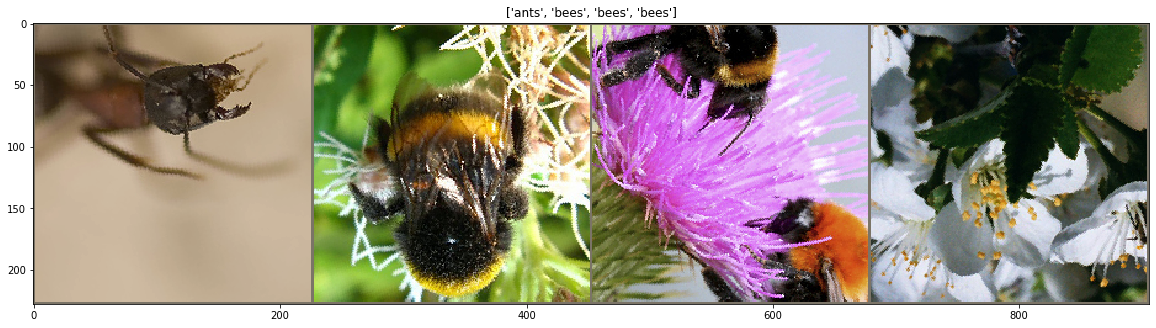

In [28]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


inputs, classes = next(iter(train_loader))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Training
The function below defines the training and validation algorithm, which also saves the best performing model. However this algorithm will always train the network a predefined number of epochs. 

__Question 3:__ Graph the validation and training loss in the same graph vs the training iterations. Can you see when the model becomes overfitted to the training data?  

__Question 4:__ Implement an early stopping alogrithm which stops the training and returns the best preforming model if a better performing model was not observed during a predefined number of epochs. Why is it a good idea to use some type of early stopping in your training alogrithm?

__Question 5:__ Calculate and visualize a multi-class confusion matrix for the validation images where the target labels are on the y-axis and predicted labels on the x-axis. An example of a multi-class confusion matrix for CIFAR10 can be seen below (1000 images per class):

![conf_matrix.png](attachment:conf_matrix.png)

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25, early_stop=-1):
    print("Epoch\t train loss\t validation loss\t train acc\t validation acc")
    start_time = time.time()

    best_model = copy.deepcopy(model.state_dict())
    best_acc = 0

    stop_counter = early_stop

    t_loss = []
    v_loss = []

    best_list_pred = []
    best_list_truth = []

    for epoch in range(num_epochs):        
        epoch_statistics = {"train_loss": 0.0, "validation_loss": 0.0, "train_corrects": 0, "validation_corrects": 0}
        # start with training the model using the training data
        model.train()
        
        running_corrects = 0

        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # reset all the calculated grads from the epoch before
            optimizer.zero_grad()

            # forward pass
            with torch.set_grad_enabled(True):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backprop 
                loss.backward()
                optimizer.step()
                scheduler.step()
                
                # stats
                epoch_statistics["train_loss"] += loss.item() * inputs.size(0)
                epoch_statistics["train_corrects"] += torch.sum(preds == labels.data)

        # validate the model against the validation data
        model.eval()

        list_pred = []
        list_truth = []
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                list_pred.append(preds)
                list_truth.append(labels.data)

                epoch_statistics["validation_loss"] += loss.item() * inputs.size(0)
                epoch_statistics["validation_corrects"] += torch.sum(preds == labels.data)

        # save the best preforming model
        if epoch_statistics["validation_corrects"].double() / val_size > best_acc:
            stop_counter = early_stop

            best_list_pred = [t.cpu() for t in list_pred]
            best_list_truth = [t.cpu() for t in list_truth]

            best_acc = epoch_statistics["validation_corrects"].double() / val_size
            best_model = copy.deepcopy(model.state_dict())

            print("Saving best model. New best val acc: {:.4f}".format(best_acc))
        else :
            stop_counter -= 1

        t_loss.append(epoch_statistics["train_loss"] / train_size)
        v_loss.append(epoch_statistics["validation_loss"] / val_size)
        print("{}/{}\t {:.4f}\t\t {:.4f}\t\t\t {:.4f}\t\t {:.4f}".format(epoch+1, num_epochs, 
                                                            epoch_statistics["train_loss"] / train_size, 
                                                            epoch_statistics["validation_loss"] / val_size, 
                                                            epoch_statistics["train_corrects"].double() / train_size,
                                                            epoch_statistics["validation_corrects"].double() / val_size))
        if stop_counter == 0 :
            break

    time_elapsed = time.time() - start_time
    print("Training completed in: {:.0f}m {:.0f}s".format(time_elapsed // 60, time_elapsed % 60))
    print("Best validation acc: {:.4f}".format(best_acc))
    

    plt.plot(range(1,len(t_loss)+1),t_loss, 'g')
    plt.plot(range(1,len(v_loss)+1),v_loss, 'r')
    plt.xlabel('Epochs')
    plt.ylabel('Score')
    plt.show()

    flat_list = [item for sublist in best_list_truth for item in sublist]


    best_cm = confusion_matrix([item for sublist in best_list_truth for item in sublist], [item for sublist in best_list_pred for item in sublist])

    import seaborn as sn
    plt.figure(figsize = best_cm.shape)
    sn.heatmap(best_cm, annot=True)

    # load the best model and return it
    model.load_state_dict(best_model)
    return model

## Transfer learning: Fine-tuning and Feature extraction
There are two main approaches to transfer learning: Fine-tuning and feature extraction.

- With fine-tuning we allow all weights of the pretrained network to be changed during the training phase.
- When using a pretrained model as a feature extractor the weights in most layers of the network are freezed and only the weights in the new output/upper layers are trained. 

This works because some low level information extracted from the input image is universal and useful in different tasks, for example edges, shapes and other common patterns. This is what the early layers are optimized to do, while later layers extract more abstract features relevant for a particular task.

The code below is an example of fine-tuning a model. In this example we are fine-tuning resnet18 which has been pretrained on [ImageNet](http://www.image-net.org/). 

__Question 6:__ The code below is an example of fine-tuning the model. Train this network and see what accuracy you get. __Make sure that before you start training everything works and you have finalized the augmentation techniques you wish to use, the training will take 15-30 minutes. Continue working on the next problem while the model is being trained.__


In [0]:
# Better printing of the model compared to print(model)
def model_info(model):
    # Plots a line-by-line description of a PyTorch model
    n_p = sum(x.numel() for x in model.parameters())  # number parameters
    n_g = sum(x.numel() for x in model.parameters() if x.requires_grad)  # number gradients
    print('\n%5s %40s %9s %12s %20s %10s %10s' % ('layer', 'name', 'gradient', 'parameters', 'shape', 'mu', 'sigma'))
    for i, (name, p) in enumerate(model.named_parameters()):
        name = name.replace('module_list.', '')
        print('%5g %40s %9s %12g %20s %10.3g %10.3g' % (
            i, name, p.requires_grad, p.numel(), list(p.shape), p.mean(), p.std()))
    print('Model Summary: %g layers, %g parameters, %g gradients' % (i + 1, n_p, n_g))


Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 240, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor



layer                                     name  gradient   parameters                shape         mu      sigma
    0                             conv1.weight      True         9408        [64, 3, 7, 7]   2.94e-05       0.13
    1                               bn1.weight      True           64                 [64]      0.258      0.123
    2                                 bn1.bias      True           64                 [64]      0.181      0.299
    3                    layer1.0.conv1.weight      True        36864       [64, 64, 3, 3]   -0.00309     0.0534
    4                      layer1.0.bn1.weight      True           64                 [64]       0.34      0.125
    5                        layer1.0.bn1.bias      True           64                 [64]    -0.0341       0.21
    6                    layer1.0.conv2.weight      True        36864       [64, 64, 3, 3]  -0.000889     0.0452
    7                      layer1.0.bn2.weight      True           64                 [64]     

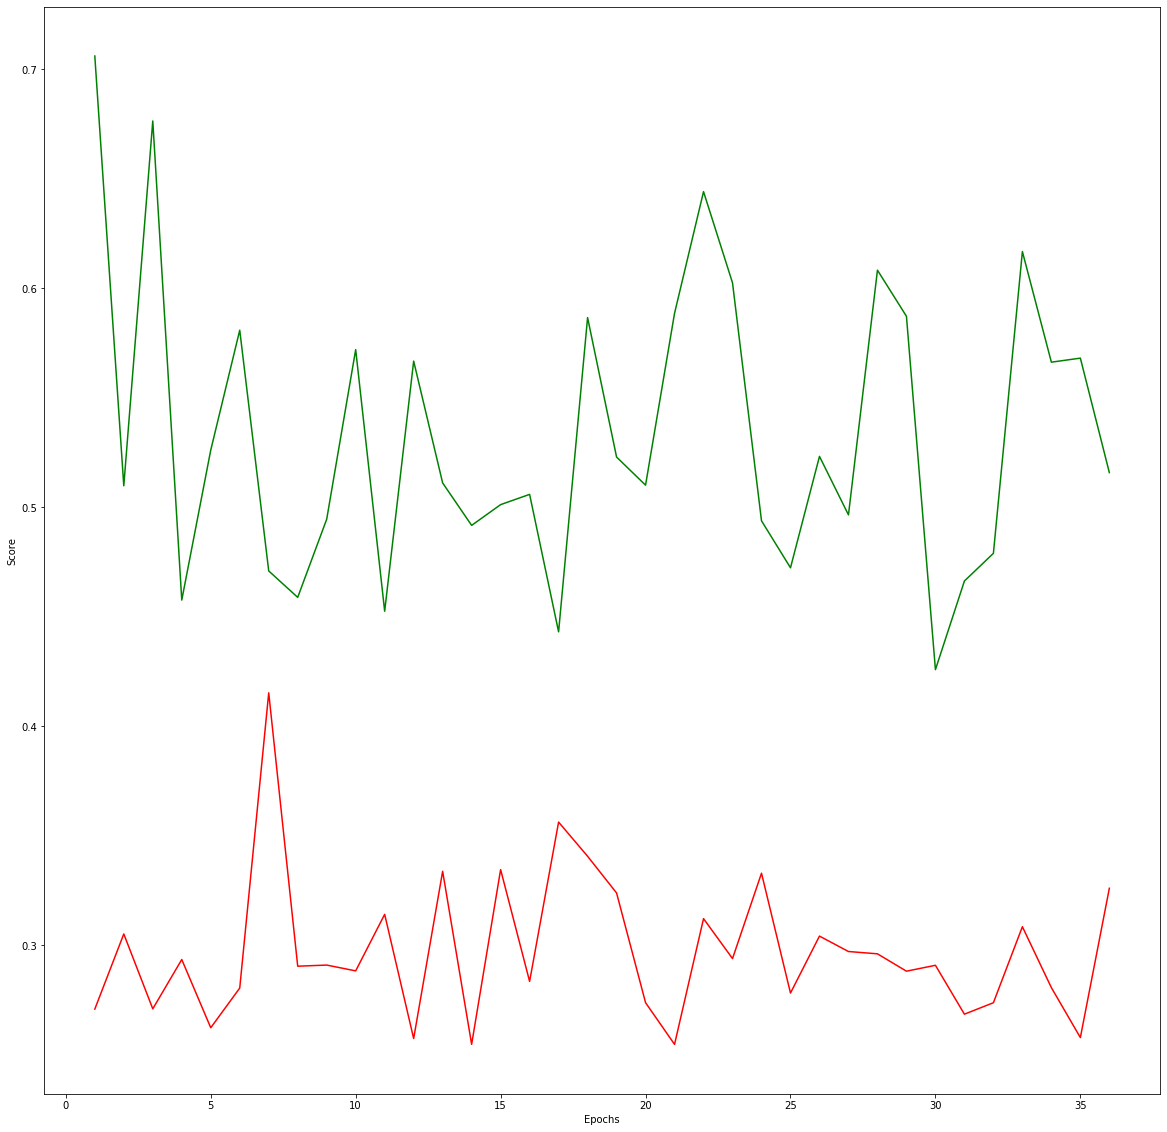

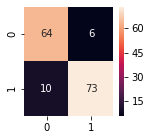

In [48]:
# load a model, pretrained on ImageNet (1000 classes)
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features

# change the output layer to match the amount of classes we have in our dataset (2)
model_ft.fc = nn.Linear(num_ftrs, len(class_names))
model_ft = model_ft.to(device)

model_info(model_ft)

# choose loss function
criterion = nn.CrossEntropyLoss()

# choose optimizer
optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# choose a LR scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=STEP_SIZE, gamma=GAMMA)

# train the model
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=50, early_stop=15)

__Question 7:__ Using the knowledge from the code given in the block above, finalize the code below and train the model using the pretrained model as a __feature extractior__. To reiterate, this means that you freeze all the layers in the model, replace the output layer and retrain it. Make sure that you use the same augmentation techniques and hyperparameters as you did above. __Do not change them now__. Use the function `model_info` to see that only the gradients in the last layer is being updated.

60 fc.weight
61 fc.bias

layer                                     name  gradient   parameters                shape         mu      sigma
    0                             conv1.weight     False         9408        [64, 3, 7, 7]   2.94e-05       0.13
    1                               bn1.weight     False           64                 [64]      0.258      0.123
    2                                 bn1.bias     False           64                 [64]      0.181      0.299
    3                    layer1.0.conv1.weight     False        36864       [64, 64, 3, 3]   -0.00309     0.0534
    4                      layer1.0.bn1.weight     False           64                 [64]       0.34      0.125
    5                        layer1.0.bn1.bias     False           64                 [64]    -0.0341       0.21
    6                    layer1.0.conv2.weight     False        36864       [64, 64, 3, 3]  -0.000889     0.0452
    7                      layer1.0.bn2.weight     False           64  

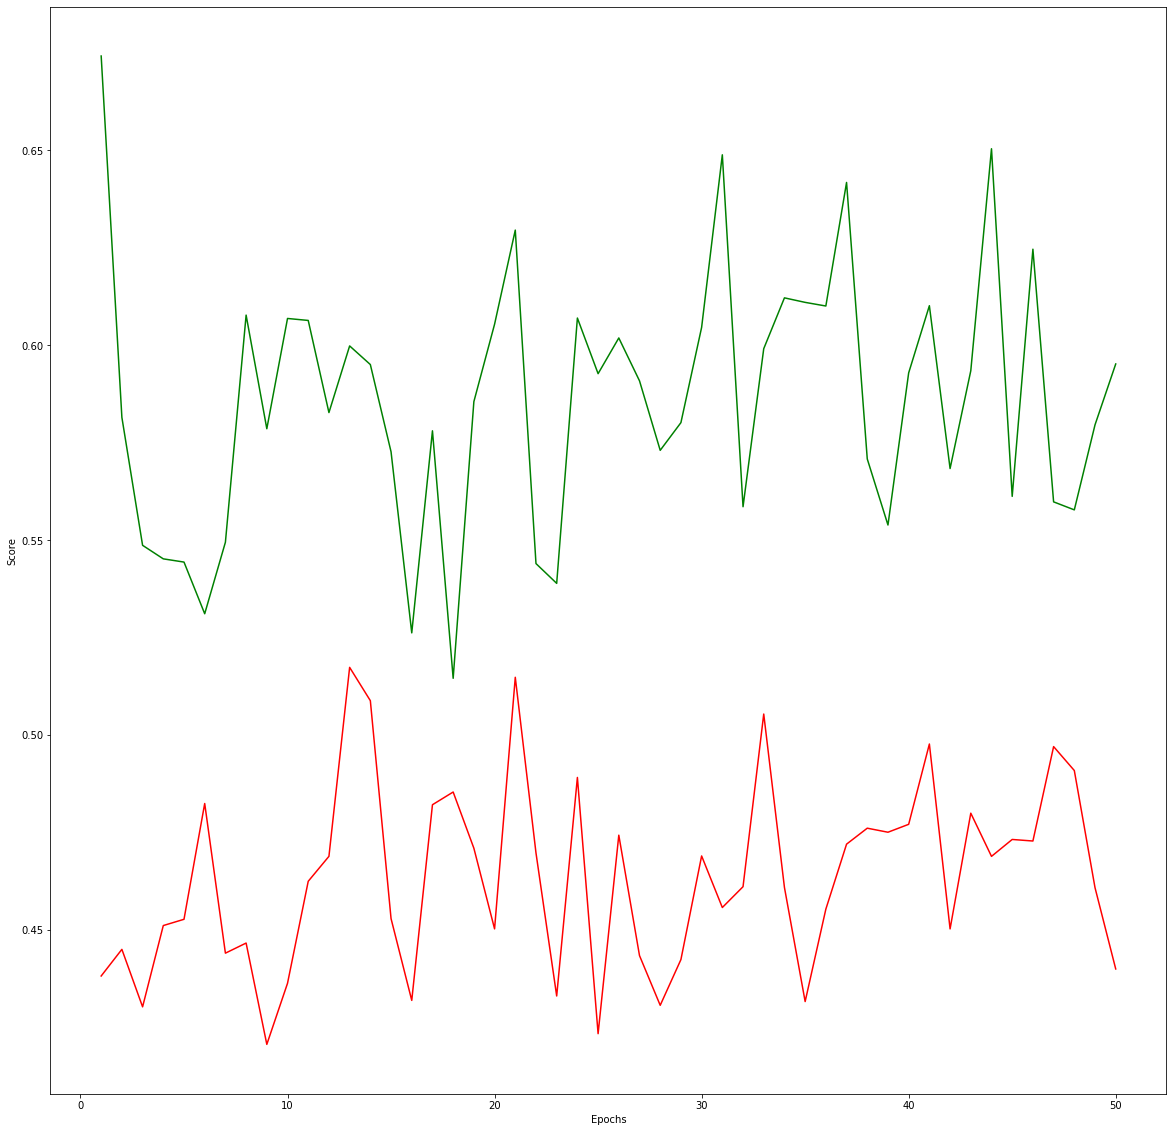

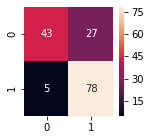

In [46]:
model_fe = torchvision.models.resnet18(pretrained=True)
for i, (name, param) in enumerate(model_fe.named_parameters()):
    if "fc" not in name :
        param.requires_grad = False
    else:
        print(i,name)

num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, len(class_names))
model_fe = model_fe.to(device)

model_info(model_fe)

# choose loss function
criterion = nn.CrossEntropyLoss()

# choose optimizer
optimizer_fe = optim.SGD(model_fe.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)

# choose a LR scheduler
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_fe, step_size=STEP_SIZE, gamma=GAMMA)

# train the model
model_fe = train_model(model_fe, criterion, optimizer_fe, exp_lr_scheduler, num_epochs=50)

__Question 8:__ How do the two different techniques compare in terms of accuracy and training speed using the same augmentation techniques and hyper parameters?

**The second one actually inproves, where the first one don't seems to. Both are equally good.** 

__Question 9:__ Discuss, what could you have changed/added to increase the accuracy of the 
 - fine-tuning model?
Increasing gamma seems to gave more consistent results. 
 - feature extractor?
Increasing the learning rate improved the results.

Lastly we visualize some validation images    

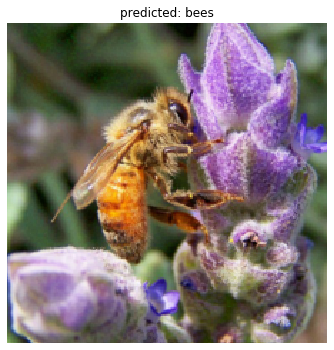

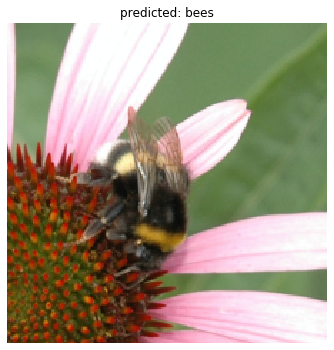

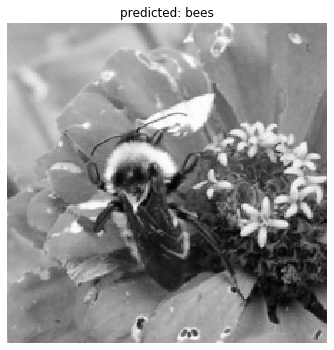

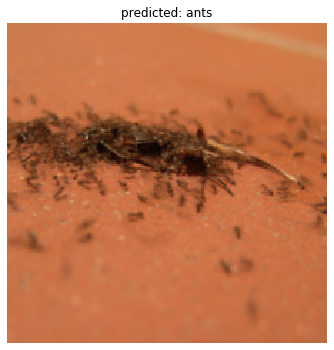

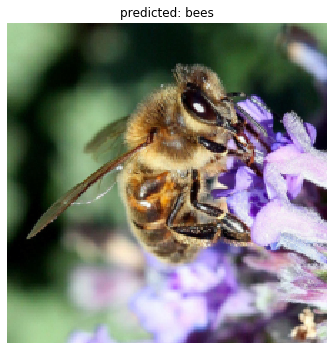

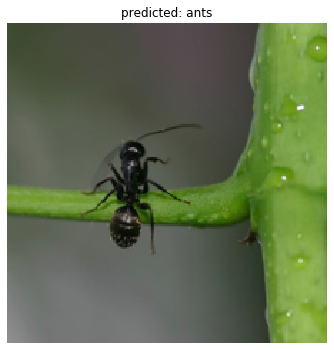

################################


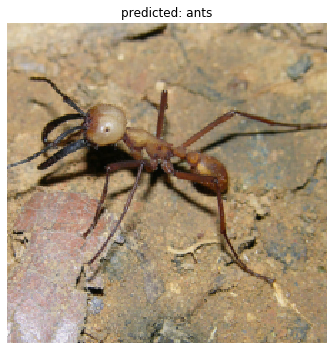

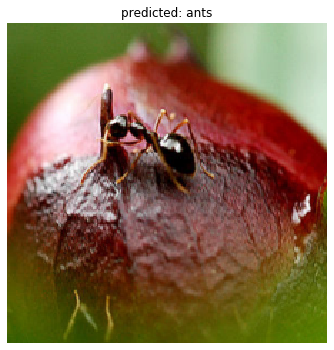

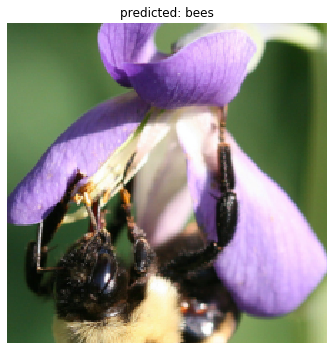

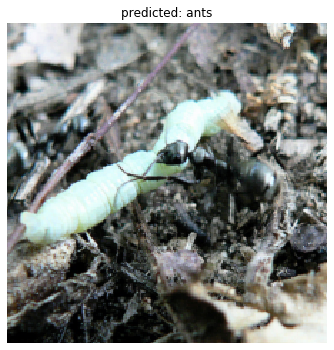

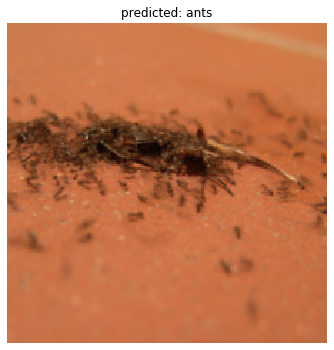

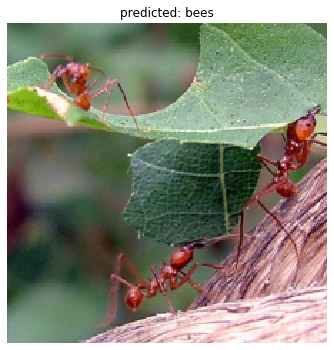

In [12]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    _ = plt.figure()

    with torch.no_grad():
        for _, (inputs, labels) in enumerate(val_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# Display a few predictions
visualize_model(model_ft)

print("#"*32)

visualize_model(model_fe)